In [55]:
from common import *

import xml.etree.ElementTree as ET
from pymongo import MongoClient
import pymongo
from matplotlib import pyplot as plt

from pymystem3 import Mystem
from bson.objectid import ObjectId
import re
from bson.son import SON
import gridfs
from pprint import pprint

In [2]:
fname = join(join(DATA_FOLDER, 'rawdata'), 'all_docs_raw.txt')

In [3]:
# all_docs = glob(join(DATA_FOLDER, 'rawdata') + '/**/*.xml', recursive=True)
# all_docs = sorted(all_docs)
# with open(fname, mode='wt', encoding='utf-8') as f:
#     f.write('\n'.join(all_docs))

In [76]:
with open(fname, mode='r', encoding='utf-8') as f:
    all_docs = f.read().splitlines()

In [ ]:
len(all_docs)

In [ ]:
def get_node(root, name, lang='ru'):
    for node in root.iter(name):
        if 'lang' in node.attrib:
            if node.attrib['lang'].lower() == lang:
                return node
        else:
            return node

In [ ]:
def parse_xml(fname, mstem, lemmatize=True, save_raw=True):
    doc = {}

    with open(fname, 'r', encoding='utf8') as f:
        text = f.read()
        text = text.replace('&deg', 'deg')
    
    try:
        root = ET.fromstring(text)
    except:
        print(fname)
        return
    
    doc.update(root.attrib)

    raw_texts = {}
    
    SDOBI = get_node(root, 'SDOBI')
    if SDOBI is not None:
        node = SDOBI.find('./B500/ru-b540/ru-b542')
        if node is not None:
            raw_texts['name'] = node.text.lower()
        else:
            print(fname)            
    else:
        print('no SDOBI: ' + fn)

    node = get_node(root, 'abstract')
    if node is not None:
        raw_texts['abstract'] = ' '.join(node.itertext()).lower()

    if SDOBI is not None:
        node = SDOBI.find('./B500/B560/ru-b560')
        if node is not None:
            doc['ru-b560'] = ' '.join(node.itertext())

    node = get_node(root, 'description')
    if node is not None:
        raw_texts['description'] = ' '.join(node.itertext()).lower()

    node = get_node(root, 'claims')
    if node is not None:
        raw_texts['claims'] = ' '.join(node.itertext()).lower()        
    
    
    for k,v in raw_texts.items():
        if save_raw:
            doc[k + '_raw'] = v
        if lemmatize:
            doc[k] = ''.join(mstem.lemmatize(v))    
    
    return doc

# Test

In [7]:
afile = '../data/rawdata/2016/RU/A/20161227/2015116494/2015116494.xml'
c1file = '../data/rawdata/2016/RU/C1/20161227/0002605713/0002605713.xml'
c2file = '../data/rawdata/2016/RU/C2/20160127/0002573901/0002573901.xml'
ufile = '../data/rawdata/2016/RU/U1/20161210/0000166582/0000166582.xml'

In [8]:
mstem = Mystem()
doc = parse_xml(c2file, mstem)

Installing mystem to /home/administrator/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz


In [21]:
print(doc['description'])

область техника настоящий изобретение относиться к способ получение поверхностный покрытие на основа поливинилхлорид (пвх), содержать слой износ на основа пвх и слой на основа поливиниловый спирт. предшествующий уровень техника поверхностный покрытие на основа пвх широко применять для декорирование сооружение, дом или транспортный средство. однако поверхностный покрытие на основа пвх обладать недостаток высвобождение летучий органический соединение (лос), некоторый из который токсичный. для уменьшение или предотвращение высвобождение лос быть предлагать замещать летучий соединение нелетучий соединение. однако этот приводить к значительный снижение жесткость поверхностный покрытие, в тот время как жесткость являться важный требование для упругий поверхностный покрытие, особенно напольный покрытие. также быть предлагать применение полиэфирный или полиамидный слой в качество защитный слой или в качество промежуточный слой в многослойный поверхностный покрытие. поливинилспиртовой (пвс) сло

In [9]:
doc

{'abstract': 'изобретение относиться к способ получение поверхностный покрытие, содержать этап обеспечение слой износ на основа пвх (1), по существо, свободный от неорганический наполнитель, нанесение на упоминать слой на основа пвх (1) композиция верхний покрытие, содержать поливиниловый спирт (пвс) и соединение силан, содержать по меньший мера один аминогруппа, нагревание упоминать слой на основа пвх (1) и упоминать композиция верхний покрытие при температура, эквивалентный или превосходить 150°c, для образование верхний покрытие слой износ (2). результат являться получение поверхностный покрытие, сочетать свойство физический устойчивость и свойство химический и газовый барьер. 2 н. и 12 з.п. ф-лы, 4 ил., 6 табла.\n',
 'abstract_raw': 'изобретение относится к способу получения поверхностного покрытия, содержащему этапы обеспечения слоя износа на основе пвх (1), по существу, свободного от неорганических наполнителей, нанесения на упомянутый слой на основе пвх (1) композиции верхнего п

# Fill database with data

In [4]:
client = MongoClient()
db = client.fips

In [6]:
# result = db.patents.create_index([('doc-number', pymongo.ASCENDING),
#                                    ('kind', pymongo.ASCENDING),
#                                    ('country', pymongo.ASCENDING),
#                                    ('date-publ', pymongo.ASCENDING)], unique=True)
# sorted(list(db.patents.index_information()))

In [6]:
def save_to_mongodb(doc_list):
    client = MongoClient()
    db = client.fips
    patents = db.patents
    
    mstem = Mystem()
    
    for fn in doc_list:
        doc = parse_xml(fn, mstem, True, True)
        if doc is not None:
            patents.insert_one(doc)

In [12]:
len(all_docs)//(cpu_count*100)

395

In [ ]:
split_on = len(all_docs)//(cpu_count*100)

for i,sub_docs in enumerate(tqdm(np.array_split(all_docs, split_on))):
    ! rm -f ../data/out
    ! echo {i} >> ../data/out
    
    parallelizer = Parallel(n_jobs=cpu_count)

    # this iterator returns the functions to execute for each task
    tasks_iterator = ( delayed(save_to_mongodb)(list_block) for 
                      list_block in grouper(100, sub_docs) ) 
    result = parallelizer( tasks_iterator )

 21%|██▏       | 84/395 [23:52<54:56, 10.60s/it]  

../data/rawdata/1999/RU/C1/19990220/0002126409/0002126409.xml


 93%|█████████▎| 369/395 [2:40:03<29:43, 68.61s/it]t]

../data/rawdata/2015/Patents/xrfd201503/DOC/RUNWC2/000/000/002/560/425/document.xml


100%|██████████| 395/395 [2:58:26<00:00, 44.67s/it]


In [16]:
# docs = []
# mstem = Mystem()

# for fn in tqdm(all_docs):
#     doc = parse_xml(fn, mstem, False, False)
#     if doc is not None:
#         patents.insert_one(doc)
# #         docs.append(doc)

In [ ]:
# patents.insert_many(docs)

# Analyze data

In [4]:
client = MongoClient()
db = client.fips

In [7]:
pipeline = [
     {"$group": {"_id": "$kind", "count": {"$sum": 1}}},
     {"$sort": SON([("count", -1), ("_id", -1)])}
 ]

pprint.pprint(list(db.patents.aggregate(pipeline)))

[{'_id': 'A ', 'count': 438164},
 {'_id': 'C1', 'count': 380857},
 {'_id': 'C2', 'count': 214003},
 {'_id': 'U1', 'count': 167301},
 {'_id': 'A1', 'count': 60184},
 {'_id': 'C ', 'count': 2527},
 {'_id': 'C9', 'count': 1372},
 {'_id': 'A2', 'count': 1028},
 {'_id': 'A3', 'count': 824},
 {'_id': 'U8', 'count': 650},
 {'_id': 'C8', 'count': 13},
 {'_id': 'A4', 'count': 13},
 {'_id': 'A8', 'count': 4}]


In [9]:
db.patents.find({ 'ru-b560': {'$exists': True}}).count()

591782

In [13]:
pipeline = [
    {"$match":{"ru-b560":{'$exists': True}}},
    {"$group": {"_id": "$kind", "count": {"$sum": 1}}},
    {"$sort": SON([("count", -1), ("_id", -1)])}
 ]

pprint.pprint(list(db.patents.aggregate(pipeline)))

[{'_id': 'C1', 'count': 363083},
 {'_id': 'C2', 'count': 213916},
 {'_id': 'A1', 'count': 10647},
 {'_id': 'C ', 'count': 2042},
 {'_id': 'C9', 'count': 1365},
 {'_id': 'A3', 'count': 398},
 {'_id': 'A2', 'count': 305},
 {'_id': 'C8', 'count': 12},
 {'_id': 'A4', 'count': 9},
 {'_id': 'U8', 'count': 4},
 {'_id': 'U1', 'count': 1}]


In [54]:
topn = db.patents.find({'kind': 'C1', 'ru-b560': {'$exists': True}}, 
                       {'ru-b560': 1, "_id": 0}).skip(24300).limit(100)
pprint(list(topn))

[{'ru-b560': 'Патент GB N 2024829, C 07G 7/00, \n\n1980.'},
 {'ru-b560': 'Авторское свидетельство СССР N 1404050, A 23 K 1/00, 1988 г.'},
 {'ru-b560': 'Авторское свидетельство СССР N 1284240, кл. C 21C 7/10,\n'
             '\n'
             ' 1985.'},
 {'ru-b560': 'Авторское свидетельство СССР N 1809185, кл. F 15B 15/22, '
             '1990.Авторское свидетельство СССР N 697763, кл. F 16F 9/48, '
             '1979.'},
 {'ru-b560': 'Преображенский В.И. Полупроводниковые выпрямители. М.: '
             'Энергоатомиздат, 1986, с.41-42.Авторское свидетельство СССР \n'
             '\n'
             'N 1684894, кл. H 02P 1/28, 1989.'},
 {'ru-b560': '1. Авторское свидетельство СССР N 415130, кл. B 23P 19/02, '
             '1974.2. Авторское свидетельство СССР N 1234152, кл. B 23P '
             '19/02,\n'
             ' 1986.'},
 {'ru-b560': 'Патент США N 4795248, кл. G 02C 7/04, 1989.'},
 {'ru-b560': 'ГОСТ 4347-77, с.2.'},
 {'ru-b560': 'Авторское свидетельство СССР N 286159, кл. C 03B 3

In [157]:
p = re.compile('(?i:ru|su)(?:\s*\d+\s*){5,}(?:A(?:1|2|3|4|8|)|C(?:1|2|8|9|)|U(?:1|8))*')

topn = db.patents.find({'ru-b560': {'$exists': True}}, 
                       {'ru-b560': 1})

regexed = {}
for doc in topn:
    found = p.findall(doc['ru-b560'])
    if len(found):
        regexed[str(doc['_id'])] = found
#         if doc['kind'] == 'C1':
#             print(doc['ru-b560'])

In [158]:
len(regexed)
# {'A1': 9, 'C1': 248427, 'C2': 194130, 'C8': 12, 'C9': 1211, 'U8': 4}

443793

In [159]:
sum([len(s) for s in regexed])

10651032

In [92]:
diff = list(set(regexed2.keys()).symmetric_difference(regexed.keys()))

In [93]:
len(diff)

110973

In [321]:
# for el in diff:
#     print(regexed2[el])

In [417]:
top10 = db.patents.find({'doc-number': {'$regex': '^[0]{0,}2077319$' }}).skip(0).limit(10)
pprint(list(top10))
print(top10.count())

[{'_id': ObjectId('5984b8c2b6b11338436384fc'),
  'abstract': 'способ лечение псориаз относиться к медицина, конкретно к '
              'дерматология. \n'
              'сущность способ заключаться в \n'
              'пероральный введение биологически активный вещество и нанесение '
              'на очаг поражение, на фон диета и нормализация режим труд и '
              'отдых, первый лечебный мазь, содержать \n'
              'свежий яичный белок, пчелиный мед,\n'
              ' крем детский, солидол. затем после исчезновение бляшка '
              'наносить второй лечебный мазь, содержать свежий яичный белок, '
              'крем детский, порошок трава чистотел. новизна \n'
              'способ состоять в то, что в \n'
              'качество биологически активный вещество вводить настойка '
              'заманиха, или элеутерококк, или золотой корень, или левзея, или '
              'аралия маньчжурский в количество 30 - 40 капля 3 \n'
              'раз в день за 30 минута д

1


# In memory search

In [8]:
topn = db.patents.find({}, {'doc-number': 1, 'country': 1, 'kind': 1})

docs = {}
for doc in topn:
    _id = str(doc['_id'])
    del doc['_id']
    doc['country'] = doc['country'].upper()
    doc['kind'] = doc['kind'].upper()
    doc['doc-number'] = doc['doc-number'].zfill(10)
    docs[_id] = doc

In [9]:
len(docs)

1266940

In [10]:
pprint(list(islice(docs.items(), 100)))

[('5984b578b6b11303c16384ee',
  {'country': 'RU', 'doc-number': '0002000715', 'kind': 'C1'}),
 ('5984b578b6b11303ca6384ee',
  {'country': 'RU', 'doc-number': '0002001615', 'kind': 'C1'}),
 ('5984b578b6b11303b26384ee',
  {'country': 'RU', 'doc-number': '0001630505', 'kind': 'C '}),
 ('5984b578b6b11303bf6384ee',
  {'country': 'RU', 'doc-number': '0002000515', 'kind': 'C1'}),
 ('5984b578b6b11303b36384ee',
  {'country': 'RU', 'doc-number': '0001376447', 'kind': 'C '}),
 ('5984b578b6b11303b66384ee',
  {'country': 'RU', 'doc-number': '0001766156', 'kind': 'C '}),
 ('5984b578b6b11303c16384ef',
  {'country': 'RU', 'doc-number': '0002000716', 'kind': 'C1'}),
 ('5984b578b6b11303b86384ee',
  {'country': 'RU', 'doc-number': '0001609340', 'kind': 'C '}),
 ('5984b578b6b11303bd6384ee',
  {'country': 'RU', 'doc-number': '0002000314', 'kind': 'C1'}),
 ('5984b578b6b11303cf6384ee',
  {'country': 'RU', 'doc-number': '0002002115', 'kind': 'C1'}),
 ('5984b578b6b11303b06384ee',
  {'country': 'RU', 'doc-numbe

In [11]:
tuples = [(v['country'], v['doc-number'], v['kind']) for k,v in docs.items()]
index = pd.MultiIndex.from_tuples(tuples, names=['country', 'doc-number', 'kind'])

In [12]:
docs_df = pd.DataFrame([k for k,v in docs.items()], index = index, columns=['_id'])
docs_df.sort_index(inplace=True)

In [13]:
docs_df

_id
country doc-number kind                          
RU      0000000001 U1    5984b623b6b1130b7e63850f
        0000000002 U1    5984b623b6b1130b7e638510
        0000000003 U1    5984b623b6b1130b7e638511
        0000000004 U1    5984b623b6b1130b7e638512
        0000000005 U1    5984b624b6b1130b7e638513
        0000000006 U1    5984b624b6b1130b7e638514
        0000000007 U1    5984b624b6b1130b7e638515
        0000000008 U1    5984b624b6b1130b7e638516
        0000000009 U1    5984b624b6b1130b7e638517
        0000000010 U1    5984b624b6b1130b7e638518
        0000000011 U1    5984b624b6b1130b7e638519
        0000000012 U1    5984b624b6b1130b7e63851a
        0000000013 U1    5984b624b6b1130b7e63851b
        0000000014 U1    5984b624b6b1130b7e63851c
        0000000015 U1    5984b624b6b1130b7e63851d
        0000000016 U1    5984b625b6b1130b7e63851e
        0000000017 U1    5984b625b6b1130b7e63851f
        0000000018 U1    5984b625b6b1130b7e638520
        0000000019 U1    5984b625b6b1130b7e638521
        0000000020 U1    5984b625b6b1130b7e638522
        0000000021 U1    5984b625b6b1130b7e638523
        0000000022 U1    5984b625b6b1130b7e638524
        0000000023 U1    5984b625b6b1130b7e638525
        0000000024 U1    5984b625b6b1130b7e638526
        0000000025 U1    5984b625b6b1130b7e638527
        0000000026 U1    5984b625b6b1130b7e638528
        0000000027 U1    5984b625b6b1130b7e638529
        0000000028 U1    5984b625b6b1130b7e63852a
        0000000029 U1    5984b625b6b1130b7e63852b
        0000000030 U1    5984b625b6b1130b7e63852c
...                                           ...
SU      0001841241 A1    5984df40b6b1133fa963852f
        0001841242 A1    5984df40b6b1133fa9638530
        0001841243 A1    5984df40b6b1133fa9638531
        0001841244 A1    5984df40b6b1133fa9638532
        0001841245 A1    5984df41b6b1133fa9638533
        0001841246 A1    5984df41b6b1133fa9638534
        0001841247 A1    5984df41b6b1133fa9638535
        0001841248 A1    5984df41b6b1133fa9638536
        0001841249 A1    5984df41b6b1133fa9638537
        0001841250 A1    5984df41b6b1133fa9638538
        0001841251 A1    5984df41b6b1133fa9638539
        0001841252 A1    5984df41b6b1133fa963853a
        0001841253 A1    5984df41b6b1133fa963853b
        0001841254 A1    5984df41b6b1133fa963853c
        0001841255 A1    5984df41b6b1133fa963853d
        0001841256 A1    5984df42b6b1133fa963853e
        0001841257 A1    5984df42b6b1133fa963853f
        0001841258 A1    5984df42b6b1133fa9638540
        0001841259 A1    5984df42b6b1133fa9638541
        0001841260 A1    5984df42b6b1133fa9638542
        0001841261 A1    5984df42b6b1133fa9638543
        0001841262 A1    5984df42b6b1133fa9638544
        0001841263 A1    5984df42b6b1133fa9638545
        0001841264 A2    5984df3db6b1133fa6638558
        0001841265 A1    5984df42b6b1133fa9638546
        0001841266 A1    5984df42b6b1133fa9638547
        0001841267 A1    5984df42b6b1133fa9638548
        0001841268 A1    5984df42b6b1133fa9638549
        0001841269 A1    5984df42b6b1133fa963854a
        0001841270 A1    5984df42b6b1133fa963854b

[1266940 rows x 1 columns]

**find index duplicates**

In [129]:
ix = docs_df.index.duplicated(keep=False)
duplicates = docs_df[ix].copy()
duplicates.sort_index(inplace=True)
duplicates

_id
country doc-number kind                          
RU      0000106307 U8    5984cfd5b6b113399d63854d
                   U8    5984d283b6b113524163852e
        0000107213 U8    5984cfd5b6b113399d63854e
                   U8    5984d283b6b113524163852b
        0000107214 U8    5984cfd5b6b113399d63854f
                   U8    5984d283b6b113524163852c
        0000107215 U8    5984cfd5b6b113399d638550
                   U8    5984d283b6b113524163852d
        0000117672 U8    5984d50cb6b1136b536384ff
                   U8    5984d50cb6b1136b53638508
        0000119532 U8    5984d27db6b1135242638526
                   U8    5984d808b6b11309046384fb
        0000139968 U8    5984d808b6b1130904638504
                   U8    5984d808b6b1130904638509
        0000797287 C     5984b658b6b11312936384f1
                   C     5984b65cb6b113129363851b
        0001067658 C     5984b658b6b11312936384f5
                   C     5984b65cb6b113129363851c
        0001124544 C     5984b658b6b113128d638504
                   C     5984b65cb6b113128d63853e
        0001244922 C     5984b659b6b1131293638502
                   C     5984b65cb6b113129363851d
        0001282376 C     5984b65ab6b1131293638505
                   C     5984b65cb6b113129363851e
        0001302560 C     5984b658b6b11312966384fa
                   C     5984b65cb6b113129563853a
        0001492571 C     5984b65ab6b1131295638512
                   C     5984b65cb6b1131295638537
        0001630039 C     5984b65bb6b1131295638522
                   C     5984b65cb6b1131295638538
...                                           ...
        0002416612 C9    5984d0c1b6b113405b6384fc
        0002421453 C9    5984cf10b6b1132e8b6384ff
                   C9    5984cf12b6b1132e8b638506
        0002441017 C9    5984d0beb6b113405b6384f6
                   C9    5984d1b8b6b113472f6384fc
        0002457303 C9    5984d676b6b1137b4f6384f9
                   C9    5984d697b6b1137b4f638534
        0002463156 C9    5984d1b6b6b113472f6384f7
                   C9    5984d492b6b11366c06384ee
                   C9    5984d498b6b11366c06384f6
        0002481696 C9    5984d4b4b6b11366c0638520
                   C9    5984d4bbb6b11366c0638532
        0002498571 C9    5984d796b6b11303dc638525
                   C9    5984d98cb6b11315e963852c
        0002540320 C9    5984db05b6b1131ed56384fa
                   C9    5984dbe3b6b113236d63851c
        0002554647 C9    5984df06b6b1133d1c638508
                   C9    5984df12b6b1133d1b63853e
        0002569635 C9    5984def8b6b1133d1d6384f4
                   C9    5984df09b6b1133d1c63850c
        0002571015 C9    5984df1bb6b1133d1c638545
                   C9    5984df1db6b1133d1b63854b
        0002582965 C9    5984df13b6b1133d1c63852d
                   C9    5984df1cb6b1133d1c638547
        2014114988 A     5984dc2eb6b113270a6384f0
                   A     5984dc30b6b113270b638523
        2014127255 A     5984dc30b6b1132713638515
                   A     5984dc30b6b113270f63851f
SU      0001045587 A1    5984badbb6b11350ee63854a
                   A1    5984c4ebb6b1134a9b638538

[1392 rows x 1 columns]

In [86]:
('RU', '0002033767') in docs_df.index

True

In [83]:
sub = docs_df.loc[('RU', '0002033767')]
sub

,_id
kind,
C1,5984b68fb6b11315936384f0
C1,5984b69db6b113159163853e


In [151]:
find = sub.index.str.find('C')
find[find >= 0]

Int64Index([0, 0], dtype='int64', name='kind')

In [17]:
max([len(v['doc-number']) for k,v in docs.items()])

10

In [18]:
class NameStruct():
    def __init__(self, name):
        name = name.upper()
        name = re.sub('\s+', '', name)
        name = name.replace('С', 'C')
        name = name.replace('А', 'A')
        self.prefix = ''
        self.number = name
        self.postfix = ''
        
        self.number = re.findall('(?<=(?i:ru|su))(?:\s*\d+\s*)+', name)[0]
        
        splited = name.replace(self.number, ' ').split()
        if len(splited):
            self.prefix = splited[0]
        if len(splited) == 2:
            self.postfix = splited[1]
                
    def __repr__(self):
        return '%s %s %s' % (self.prefix, self.number, self.postfix)


In [130]:
print(NameStruct('SU 1   6  2 180 6A1'))
print(NameStruct('RU 162 180 6A1'))
print(NameStruct('rU 162 180 6 A1'))
print(NameStruct('Su1621806A1'))
print(NameStruct('SU1621806A'))
print(NameStruct('SU162180 6'))
print(NameStruct('SU1621806'))
print(NameStruct('SU 1621806'))


SU 1621806 A1
RU 1621806 A1
RU 1621806 A1
SU 1621806 A1
SU 1621806 A
SU 1621806 
SU 1621806 
SU 1621806 


In [20]:
re.findall('(?<=(?i:ru|su))(?:\s*\d+\s*)+', 'SU 1621806')

[' 1621806']

In [168]:
def find_doc(docs_df, name_struct):
    if int(name_struct.number) == 0:
        assert False
    
    if (name_struct.prefix, name_struct.number) in docs_df.index:
        sub = docs_df.loc[(name_struct.prefix, name_struct.number)]
        if len(sub) == 1:
            return sub.iloc[0]._id
    else:
        return
    
    sub_index = sub.index.str.find(name_struct.postfix)
    find = sub_index[sub_index >= 0]
    if len(find) == 0:
        return
    else:
        return sub.iloc[find[0]]._id

In [161]:
nst = NameStruct('RU 2077319 ')
nst.number = nst.number.zfill(10)

find_doc(docs_df, nst)

'5984b8c2b6b11338436384fc'

In [162]:
names = {}
for _id,v in tqdm(regexed.items()):
    structs = []
    for s in v:
        nst = NameStruct(s)
        nst.number = nst.number.zfill(10)
        structs.append(nst)
    if len(structs):
        names[_id] = structs

100%|██████████| 443793/443793 [00:18<00:00, 24468.95it/s]


In [163]:
pprint(list(islice(names.items(), 100)))

[('5984b67fb6b11314886384fc', [SU 0008900015 ]),
 ('5984b6e7b6b11319ba6384f6', [SU 0001761279 ]),
 ('5984b704b6b1131ad1638518', [SU 0001534017 , SU 0001379254 ]),
 ('5984b7bab6b11328566384f1', [SU 0001296187 ]),
 ('5984b7bab6b11328566384f2', [SU 0001326300 ]),
 ('5984b7bdb6b1132856638509', [SU 0001824239 ]),
 ('5984b7bfb6b113285d638516', [SU 0001451338 ]),
 ('5984b7bfb6b113285d638518', [SU 0001558106 ]),
 ('5984b7c1b6b1132857638526', [SU 0001689321 , SU 0000663669 ]),
 ('5984b7c2b6b1132856638528', [RU 0001767801 ]),
 ('5984b7c3b6b113286f638536', [SU 0000914545 , SU 0001051052 ]),
 ('5984b7c3b6b113285c638509', [SU 0000344088 ]),
 ('5984b7c5b6b113285c638519', [SU 0000777190 ]),
 ('5984b7c5b6b113285463854b', [SU 0001801342 ]),
 ('5984b7d9b6b1132963638534', [SU 0001617014 , SU 0000322378 ]),
 ('5984b7e8b6b1132a87638508', [RU 0001818307 ]),
 ('5984b7f5b6b1132a8263854a', [SU 0001668794 ]),
 ('5984b980b6b113401d638515', [RU 0002026079 C]),
 ('5984b9e9b6b11347c1638543', [SU 0000202439 ]),
 ('5

In [170]:
res = {}
for _id, nst_list in tqdm(names.items()):
    found = []
    for nst in nst_list:
        f_id = find_doc(docs_df, nst)
        if f_id is not None:
            found.append(f_id)
    if len(found):
        res[_id] = found


100%|██████████| 443793/443793 [16:12<00:00, 456.21it/s]


In [179]:
print('%s of %s regexed' % (len(res), len(regexed)))

368458 of 443793 regexed


In [180]:
sum([len(s) for s in res])

8842992

In [181]:
pprint(list(islice(res.items(), 100)))

[('5984b7c2b6b1132856638528', ['5984b65cb6b1131291638512']),
 ('5984b980b6b113401d638515', ['5984b65cb6b113129b638521']),
 ('5984b9f9b6b11348ca63850f', ['5984b71fb6b1131bef638550']),
 ('5984b9fab6b11348c163851e', ['5984b65ab6b113129b638508']),
 ('5984ba05b6b11348c1638540', ['5984b680b6b1131490638515']),
 ('5984ba11b6b11349ec6384f0',
  ['5984b688b6b113147e638533',
   '5984b5dbb6b1130839638502',
   '5984b832b6b1132dc8638509']),
 ('5984ba15b6b11349ee638507', ['5984b78bb6b113254c63852e']),
 ('5984ba15b6b11349ee638508', ['5984b584b6b11303c1638551']),
 ('5984ba17b6b11349f563850c', ['5984b787b6b113256063850b']),
 ('5984ba17b6b11349f563850d', ['5984b5ccb6b113073663853e']),
 ('5984ba17b6b11349f5638510', ['5984b653b6b11311c963852f']),
 ('5984ba1db6b11349ee63852c', ['5984b6efb6b11319d463852b']),
 ('5984ba1db6b11349e863851e',
  ['5984b791b6b113254d63854d',
   '5984b584b6b11303c963854e',
   '5984b7e9b6b1132a7f638508']),
 ('5984ba1db6b11349ee63852e',
  ['5984b69eb6b113159a63854d',
   '5984b7c4b6b113

In [182]:
lens = pd.Series([len(v) for k,v in res.items()], index=[k for k,v in res.items()])
pprint(lens.describe())
# 'способ разработки нефтяной залежи на поздней стадии эксплуатации'
lens.argmax()

count    368458.000000
mean          2.076288
std           1.194851
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          14.000000
dtype: float64


'5984bbafb6b1135c3863850c'

In [183]:
counter = {}
for k,v in res.items():
    for s in v:
        if s in counter:
            counter[s] += 1
        else:
            counter[s] = 1

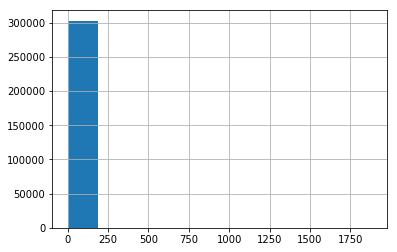

count    302989.000000
mean          2.524927
std           8.472599
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1884.000000
dtype: float64


In [184]:
counts = pd.Series([v for k,v in counter.items()], index = [k for k,v in counter.items()])
counts.hist()

plt.show()
print(counts.describe())


In [185]:
counts[counts.argsort()[::-1]]
# 5984c6fbb6b113623d63851f
# 'способ производства инстант-порошка из растительного сырья'

5984c6fbb6b113623d63851f    1884
5984c297b6b11331626384f3    1298
5984b582b6b11303ba638525    1280
5984c11bb6b1131e66638511     859
5984b7d5b6b1132953638517     845
5984b97bb6b11340306384fd     797
5984b9fbb6b11348ac63852c     771
5984b808b6b1132b9a638514     700
5984be8bb6b1137ec063851e     694
5984b896b6b113354263853f     614
5984c477b6b113450263854b     591
5984c094b6b11319de638516     548
5984b694b6b113159e638510     529
5984bd8fb6b113730f638548     522
5984b7e9b6b1132a8563850f     518
5984bb4ab6b113587963852a     514
5984c472b6b113450863853a     509
5984c446b6b11343ad638544     501
5984c564b6b113508f638536     486
5984bcd7b6b11368ff63851f     484
5984c477b6b113450263854c     454
5984b960b6b1133ef1638517     445
5984c70bb6b113633c6384f6     431
5984ba88b6b1134d6d63851c     416
5984c711b6b113634963850a     416
5984bc90b6b11366a5638501     401
5984c283b6b1133010638549     382
5984be8bb6b1137ec063851d     377
5984bd80b6b1137302638501     372
5984c4b3b6b11347a2638503     353
          

# Save b560 valid links to mongo

In [198]:
client = MongoClient()
db = client.fips

for k,v in tqdm(res.items()):
    db.patents.update_one({'_id': ObjectId(k)}, {"$set": {'similar':v}}, upsert=False)

100%|██████████| 368458/368458 [07:26<00:00, 825.23it/s] 


# Get w2v

##### tokenize docs and save for fast access

In [2]:
client = MongoClient()
db = client.fips

dim = 300

def json2text(doc):
    text = ''
    if 'name' in doc:
        text += doc['name'] + '.\n'
    if 'abstract' in doc:
        text += doc['abstract'] + '.\n'
    if '"description"' in doc:
        text += doc['description'] + '.\n'
    if 'claims' in doc:
        text += doc['claims']

    return text

In [5]:
# db.patents.update_many({}, {'$unset': {'tokenized':1}})

/home/administrator/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.
  """Entry point for launching an IPython kernel.


{'n': 1266940, 'nModified': 1266940, 'ok': 1, 'updatedExisting': True}

In [62]:
# db.corpus.update_one({'tokenized': 'simple'}, {'$set': {'docs':[]}})

def save_corpus(ids, prefix):
    client = MongoClient()
    db = client.fips
    
    docs = []
    
    for _id in ids:
        doc_tokenized = []
        
        doc = db.patents.find_one({'_id': _id}, 
                                  {'name': 1, 'abstract': 1, 
                                   'description': 1, 'claims': 1})
        text = json2text(doc)
        for sentence in nltk.sent_tokenize(text):
            tokenized_sent = list(tokenize(sentence, stop_list=simple_stop_list))
            if len(tokenized_sent) > 1:
                doc_tokenized.append(tokenized_sent)
        
        if len(doc_tokenized):
            docs.append(doc_tokenized)
    
    fname = join(DATA_FOLDER, 'documents/%s' % prefix + '.json.gz')
    with GzipFile(fname, 'w') as fout:
        json_str = json.dumps(docs)
        json_bytes = json_str.encode('utf-8')

        fout.write(json_bytes)

In [4]:
docs_ids = [doc['_id'] for doc in db.patents.find({}, {'_id': 1}) ]

In [ ]:
parallelizer = Parallel(n_jobs=cpu_count)

# this iterator returns the functions to execute for each task
tasks_iterator = ( delayed(save_corpus)(list_block, i) for 
                  i, list_block in enumerate(grouper(len(docs_ids)//1000, docs_ids)) ) 
result = parallelizer( tasks_iterator )

In [ ]:
! echo 'finished json2text' > ../data/out

In [ ]:
# iter only over 

class Sentences(object):
    def __init__(self, folder):
        self.folder = folder
 
    def __iter__(self):
        for fn in glob(join(self.folder, '*.gz')):
            with GzipFile(fn, 'r') as myzip:
                text = myzip.read()
            docs = json.loads(text)
            for doc in docs:
                for sentence in doc:
                    yield sentence

In [ ]:
model = Word2Vec(Sentences(join(DATA_FOLDER, 'documents/')), size=dim, 
                 sg=1, min_count=5, window=10, workers=cpu_count)

2017-08-09 04:41:24,285 : INFO : collecting all words and their counts
2017-08-09 04:41:24,419 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-08-09 04:41:25,094 : INFO : PROGRESS: at sentence #10000, processed 185763 words, keeping 18214 word types
2017-08-09 04:41:26,345 : INFO : PROGRESS: at sentence #20000, processed 372401 words, keeping 27637 word types
2017-08-09 04:41:27,010 : INFO : PROGRESS: at sentence #30000, processed 556710 words, keeping 35937 word types
2017-08-09 04:41:27,670 : INFO : PROGRESS: at sentence #40000, processed 744663 words, keeping 45051 word types
2017-08-09 04:41:28,346 : INFO : PROGRESS: at sentence #50000, processed 946228 words, keeping 52837 word types
2017-08-09 04:41:29,015 : INFO : PROGRESS: at sentence #60000, processed 1144975 words, keeping 60424 word types
2017-08-09 04:41:29,818 : INFO : PROGRESS: at sentence #70000, processed 1328756 words, keeping 66737 word types
2017-08-09 04:41:30,506 : INFO : PROGRESS: a

2017-08-09 04:42:19,151 : INFO : PROGRESS: at sentence #710000, processed 13227912 words, keeping 206023 word types
2017-08-09 04:42:20,559 : INFO : PROGRESS: at sentence #720000, processed 13417750 words, keeping 206812 word types
2017-08-09 04:42:21,229 : INFO : PROGRESS: at sentence #730000, processed 13609158 words, keeping 207595 word types
2017-08-09 04:42:21,937 : INFO : PROGRESS: at sentence #740000, processed 13800970 words, keeping 208424 word types
2017-08-09 04:42:22,653 : INFO : PROGRESS: at sentence #750000, processed 13994913 words, keeping 209157 word types
2017-08-09 04:42:23,368 : INFO : PROGRESS: at sentence #760000, processed 14189485 words, keeping 209819 word types
2017-08-09 04:42:24,030 : INFO : PROGRESS: at sentence #770000, processed 14366238 words, keeping 210977 word types
2017-08-09 04:42:25,284 : INFO : PROGRESS: at sentence #780000, processed 14561608 words, keeping 211528 word types
2017-08-09 04:42:25,942 : INFO : PROGRESS: at sentence #790000, processe

2017-08-09 04:43:14,246 : INFO : PROGRESS: at sentence #1420000, processed 26370610 words, keeping 274376 word types
2017-08-09 04:43:14,943 : INFO : PROGRESS: at sentence #1430000, processed 26556892 words, keeping 275109 word types
2017-08-09 04:43:15,618 : INFO : PROGRESS: at sentence #1440000, processed 26742533 words, keeping 275804 word types
2017-08-09 04:43:16,427 : INFO : PROGRESS: at sentence #1450000, processed 26920136 words, keeping 276491 word types
2017-08-09 04:43:17,188 : INFO : PROGRESS: at sentence #1460000, processed 27096950 words, keeping 277152 word types
2017-08-09 04:43:17,871 : INFO : PROGRESS: at sentence #1470000, processed 27283625 words, keeping 277820 word types
2017-08-09 04:43:18,581 : INFO : PROGRESS: at sentence #1480000, processed 27464084 words, keeping 278379 word types
2017-08-09 04:43:19,842 : INFO : PROGRESS: at sentence #1490000, processed 27652269 words, keeping 279413 word types
2017-08-09 04:43:20,507 : INFO : PROGRESS: at sentence #1500000,

2017-08-09 04:44:09,377 : INFO : PROGRESS: at sentence #2130000, processed 39774190 words, keeping 321315 word types
2017-08-09 04:44:10,728 : INFO : PROGRESS: at sentence #2140000, processed 39968065 words, keeping 321865 word types
2017-08-09 04:44:11,425 : INFO : PROGRESS: at sentence #2150000, processed 40160582 words, keeping 322589 word types
2017-08-09 04:44:12,108 : INFO : PROGRESS: at sentence #2160000, processed 40348320 words, keeping 323299 word types
2017-08-09 04:44:12,785 : INFO : PROGRESS: at sentence #2170000, processed 40534245 words, keeping 323889 word types
2017-08-09 04:44:13,455 : INFO : PROGRESS: at sentence #2180000, processed 40719242 words, keeping 324597 word types
2017-08-09 04:44:14,158 : INFO : PROGRESS: at sentence #2190000, processed 40904991 words, keeping 325129 word types
2017-08-09 04:44:14,876 : INFO : PROGRESS: at sentence #2200000, processed 41095241 words, keeping 325642 word types
2017-08-09 04:44:16,191 : INFO : PROGRESS: at sentence #2210000,

2017-08-09 04:45:04,910 : INFO : PROGRESS: at sentence #2840000, processed 53292758 words, keeping 440944 word types
2017-08-09 04:45:06,287 : INFO : PROGRESS: at sentence #2850000, processed 53477192 words, keeping 441278 word types
2017-08-09 04:45:06,977 : INFO : PROGRESS: at sentence #2860000, processed 53651712 words, keeping 441793 word types
2017-08-09 04:45:07,663 : INFO : PROGRESS: at sentence #2870000, processed 53826262 words, keeping 442230 word types
2017-08-09 04:45:08,345 : INFO : PROGRESS: at sentence #2880000, processed 54000925 words, keeping 442717 word types
2017-08-09 04:45:09,017 : INFO : PROGRESS: at sentence #2890000, processed 54181628 words, keeping 443113 word types
2017-08-09 04:45:09,689 : INFO : PROGRESS: at sentence #2900000, processed 54357921 words, keeping 443544 word types
2017-08-09 04:45:10,390 : INFO : PROGRESS: at sentence #2910000, processed 54541249 words, keeping 443916 word types
2017-08-09 04:45:11,088 : INFO : PROGRESS: at sentence #2920000,

2017-08-09 04:46:00,251 : INFO : PROGRESS: at sentence #3550000, processed 66159240 words, keeping 495704 word types
2017-08-09 04:46:00,955 : INFO : PROGRESS: at sentence #3560000, processed 66334642 words, keeping 496750 word types
2017-08-09 04:46:01,632 : INFO : PROGRESS: at sentence #3570000, processed 66518959 words, keeping 497550 word types
2017-08-09 04:46:02,992 : INFO : PROGRESS: at sentence #3580000, processed 66694090 words, keeping 498565 word types
2017-08-09 04:46:03,689 : INFO : PROGRESS: at sentence #3590000, processed 66868400 words, keeping 499189 word types
2017-08-09 04:46:04,412 : INFO : PROGRESS: at sentence #3600000, processed 67060715 words, keeping 499956 word types
2017-08-09 04:46:05,135 : INFO : PROGRESS: at sentence #3610000, processed 67254118 words, keeping 500642 word types
2017-08-09 04:46:05,922 : INFO : PROGRESS: at sentence #3620000, processed 67429401 words, keeping 501518 word types
2017-08-09 04:46:06,640 : INFO : PROGRESS: at sentence #3630000,

2017-08-09 04:46:58,615 : INFO : PROGRESS: at sentence #4260000, processed 79716126 words, keeping 538046 word types
2017-08-09 04:46:59,316 : INFO : PROGRESS: at sentence #4270000, processed 79896025 words, keeping 538526 word types
2017-08-09 04:47:00,012 : INFO : PROGRESS: at sentence #4280000, processed 80085340 words, keeping 538969 word types
2017-08-09 04:47:00,722 : INFO : PROGRESS: at sentence #4290000, processed 80268530 words, keeping 539514 word types
2017-08-09 04:47:01,463 : INFO : PROGRESS: at sentence #4300000, processed 80448862 words, keeping 540359 word types
2017-08-09 04:47:02,203 : INFO : PROGRESS: at sentence #4310000, processed 80627405 words, keeping 540813 word types
2017-08-09 04:47:02,914 : INFO : PROGRESS: at sentence #4320000, processed 80809085 words, keeping 541357 word types
2017-08-09 04:47:04,398 : INFO : PROGRESS: at sentence #4330000, processed 81002041 words, keeping 541833 word types
2017-08-09 04:47:05,108 : INFO : PROGRESS: at sentence #4340000,

2017-08-09 04:47:55,107 : INFO : PROGRESS: at sentence #4970000, processed 92985082 words, keeping 665901 word types
2017-08-09 04:47:55,805 : INFO : PROGRESS: at sentence #4980000, processed 93160336 words, keeping 666280 word types
2017-08-09 04:47:56,487 : INFO : PROGRESS: at sentence #4990000, processed 93339768 words, keeping 666610 word types
2017-08-09 04:47:57,813 : INFO : PROGRESS: at sentence #5000000, processed 93526245 words, keeping 666939 word types
2017-08-09 04:47:58,639 : INFO : PROGRESS: at sentence #5010000, processed 93708474 words, keeping 667294 word types
2017-08-09 04:47:59,355 : INFO : PROGRESS: at sentence #5020000, processed 93872280 words, keeping 667664 word types
2017-08-09 04:48:00,077 : INFO : PROGRESS: at sentence #5030000, processed 94046337 words, keeping 667954 word types
2017-08-09 04:48:00,763 : INFO : PROGRESS: at sentence #5040000, processed 94226450 words, keeping 668192 word types
2017-08-09 04:48:01,467 : INFO : PROGRESS: at sentence #5050000,

2017-08-09 05:12:15,491 : INFO : PROGRESS: at sentence #22470000, processed 433911028 words, keeping 1949287 word types
2017-08-09 05:12:16,257 : INFO : PROGRESS: at sentence #22480000, processed 434112974 words, keeping 1949950 word types
2017-08-09 05:12:16,983 : INFO : PROGRESS: at sentence #22490000, processed 434298589 words, keeping 1950263 word types
2017-08-09 05:12:17,720 : INFO : PROGRESS: at sentence #22500000, processed 434495565 words, keeping 1950571 word types
2017-08-09 05:12:19,135 : INFO : PROGRESS: at sentence #22510000, processed 434704541 words, keeping 1950960 word types
2017-08-09 05:12:19,883 : INFO : PROGRESS: at sentence #22520000, processed 434872536 words, keeping 1951261 word types
2017-08-09 05:12:20,632 : INFO : PROGRESS: at sentence #22530000, processed 435076438 words, keeping 1951701 word types
2017-08-09 05:12:21,420 : INFO : PROGRESS: at sentence #22540000, processed 435281050 words, keeping 1951920 word types
2017-08-09 05:12:22,297 : INFO : PROGRES

2017-08-09 05:13:15,628 : INFO : PROGRESS: at sentence #23160000, processed 447676593 words, keeping 1969986 word types
2017-08-09 05:13:16,491 : INFO : PROGRESS: at sentence #23170000, processed 447884851 words, keeping 1970166 word types
2017-08-09 05:13:17,868 : INFO : PROGRESS: at sentence #23180000, processed 448098766 words, keeping 1970341 word types
2017-08-09 05:13:18,640 : INFO : PROGRESS: at sentence #23190000, processed 448314010 words, keeping 1970534 word types
2017-08-09 05:13:19,391 : INFO : PROGRESS: at sentence #23200000, processed 448525111 words, keeping 1970756 word types
2017-08-09 05:13:20,751 : INFO : PROGRESS: at sentence #23210000, processed 448741925 words, keeping 1970993 word types
2017-08-09 05:13:21,507 : INFO : PROGRESS: at sentence #23220000, processed 448980023 words, keeping 1971165 word types
2017-08-09 05:13:22,266 : INFO : PROGRESS: at sentence #23230000, processed 449205516 words, keeping 1971340 word types
2017-08-09 05:13:23,604 : INFO : PROGRES

2017-08-09 05:14:26,517 : INFO : PROGRESS: at sentence #23850000, processed 463984805 words, keeping 1988201 word types
2017-08-09 05:14:27,248 : INFO : PROGRESS: at sentence #23860000, processed 464191282 words, keeping 1988420 word types
2017-08-09 05:14:27,984 : INFO : PROGRESS: at sentence #23870000, processed 464390744 words, keeping 1988610 word types
2017-08-09 05:14:28,702 : INFO : PROGRESS: at sentence #23880000, processed 464601776 words, keeping 1988771 word types
2017-08-09 05:14:30,051 : INFO : PROGRESS: at sentence #23890000, processed 464805470 words, keeping 1988992 word types
2017-08-09 05:14:30,955 : INFO : PROGRESS: at sentence #23900000, processed 465029079 words, keeping 1989201 word types
2017-08-09 05:14:31,720 : INFO : PROGRESS: at sentence #23910000, processed 465238096 words, keeping 1989441 word types
2017-08-09 05:14:32,476 : INFO : PROGRESS: at sentence #23920000, processed 465443751 words, keeping 1989651 word types
2017-08-09 05:14:33,833 : INFO : PROGRES

2017-08-09 05:15:26,507 : INFO : PROGRESS: at sentence #24540000, processed 477656908 words, keeping 2006081 word types
2017-08-09 05:15:27,233 : INFO : PROGRESS: at sentence #24550000, processed 477849915 words, keeping 2006483 word types
2017-08-09 05:15:27,965 : INFO : PROGRESS: at sentence #24560000, processed 478032361 words, keeping 2006808 word types
2017-08-09 05:15:29,323 : INFO : PROGRESS: at sentence #24570000, processed 478229516 words, keeping 2007109 word types
2017-08-09 05:15:30,091 : INFO : PROGRESS: at sentence #24580000, processed 478429408 words, keeping 2007305 word types
2017-08-09 05:15:30,946 : INFO : PROGRESS: at sentence #24590000, processed 478623094 words, keeping 2007506 word types
2017-08-09 05:15:31,692 : INFO : PROGRESS: at sentence #24600000, processed 478813221 words, keeping 2007759 word types
2017-08-09 05:15:32,443 : INFO : PROGRESS: at sentence #24610000, processed 479007229 words, keeping 2008006 word types
2017-08-09 05:15:33,181 : INFO : PROGRES

2017-08-09 05:16:24,525 : INFO : PROGRESS: at sentence #25230000, processed 491063902 words, keeping 2026013 word types
2017-08-09 05:16:25,855 : INFO : PROGRESS: at sentence #25240000, processed 491273471 words, keeping 2026190 word types
2017-08-09 05:16:26,585 : INFO : PROGRESS: at sentence #25250000, processed 491464246 words, keeping 2026659 word types
2017-08-09 05:16:27,319 : INFO : PROGRESS: at sentence #25260000, processed 491658862 words, keeping 2026822 word types
2017-08-09 05:16:28,204 : INFO : PROGRESS: at sentence #25270000, processed 491857114 words, keeping 2027033 word types
2017-08-09 05:16:28,950 : INFO : PROGRESS: at sentence #25280000, processed 492062066 words, keeping 2027235 word types
2017-08-09 05:16:30,261 : INFO : PROGRESS: at sentence #25290000, processed 492258289 words, keeping 2027418 word types
2017-08-09 05:16:31,035 : INFO : PROGRESS: at sentence #25300000, processed 492468388 words, keeping 2027670 word types
2017-08-09 05:16:31,795 : INFO : PROGRES

2017-08-09 05:17:25,792 : INFO : PROGRESS: at sentence #25920000, processed 504907234 words, keeping 2043283 word types
2017-08-09 05:17:27,178 : INFO : PROGRESS: at sentence #25930000, processed 505127764 words, keeping 2043445 word types
2017-08-09 05:17:28,042 : INFO : PROGRESS: at sentence #25940000, processed 505355550 words, keeping 2043631 word types
2017-08-09 05:17:29,402 : INFO : PROGRESS: at sentence #25950000, processed 505592077 words, keeping 2043746 word types
2017-08-09 05:17:30,129 : INFO : PROGRESS: at sentence #25960000, processed 505807391 words, keeping 2043920 word types
2017-08-09 05:17:30,889 : INFO : PROGRESS: at sentence #25970000, processed 506031446 words, keeping 2044049 word types
2017-08-09 05:17:31,638 : INFO : PROGRESS: at sentence #25980000, processed 506250520 words, keeping 2044213 word types
2017-08-09 05:17:32,974 : INFO : PROGRESS: at sentence #25990000, processed 506470108 words, keeping 2044342 word types
2017-08-09 05:17:33,752 : INFO : PROGRES

2017-08-09 05:18:36,545 : INFO : PROGRESS: at sentence #26610000, processed 521211850 words, keeping 2057642 word types
2017-08-09 05:18:37,925 : INFO : PROGRESS: at sentence #26620000, processed 521465782 words, keeping 2057766 word types
2017-08-09 05:18:38,705 : INFO : PROGRESS: at sentence #26630000, processed 521700937 words, keeping 2057906 word types
2017-08-09 05:18:39,459 : INFO : PROGRESS: at sentence #26640000, processed 521926205 words, keeping 2057998 word types
2017-08-09 05:18:40,850 : INFO : PROGRESS: at sentence #26650000, processed 522163934 words, keeping 2058173 word types
2017-08-09 05:18:41,639 : INFO : PROGRESS: at sentence #26660000, processed 522428162 words, keeping 2058337 word types
2017-08-09 05:18:42,979 : INFO : PROGRESS: at sentence #26670000, processed 522666647 words, keeping 2058489 word types
2017-08-09 05:18:43,763 : INFO : PROGRESS: at sentence #26680000, processed 522916927 words, keeping 2058633 word types
2017-08-09 05:18:45,304 : INFO : PROGRES

2017-08-09 05:19:40,729 : INFO : PROGRESS: at sentence #27300000, processed 536049585 words, keeping 2072829 word types
2017-08-09 05:19:41,497 : INFO : PROGRESS: at sentence #27310000, processed 536251558 words, keeping 2073608 word types
2017-08-09 05:19:42,239 : INFO : PROGRESS: at sentence #27320000, processed 536444567 words, keeping 2073802 word types
2017-08-09 05:19:43,558 : INFO : PROGRESS: at sentence #27330000, processed 536640525 words, keeping 2074009 word types
2017-08-09 05:19:44,296 : INFO : PROGRESS: at sentence #27340000, processed 536835420 words, keeping 2074241 word types
2017-08-09 05:19:45,170 : INFO : PROGRESS: at sentence #27350000, processed 537026656 words, keeping 2074531 word types
2017-08-09 05:19:45,919 : INFO : PROGRESS: at sentence #27360000, processed 537224108 words, keeping 2074767 word types
2017-08-09 05:19:46,663 : INFO : PROGRESS: at sentence #27370000, processed 537425341 words, keeping 2075047 word types
2017-08-09 05:19:47,445 : INFO : PROGRES

2017-08-09 05:20:39,472 : INFO : PROGRESS: at sentence #27990000, processed 549622220 words, keeping 2093006 word types
2017-08-09 05:20:40,269 : INFO : PROGRESS: at sentence #28000000, processed 549830693 words, keeping 2093256 word types
2017-08-09 05:20:41,002 : INFO : PROGRESS: at sentence #28010000, processed 550026158 words, keeping 2093689 word types
2017-08-09 05:20:41,722 : INFO : PROGRESS: at sentence #28020000, processed 550217464 words, keeping 2093933 word types
2017-08-09 05:20:43,185 : INFO : PROGRESS: at sentence #28030000, processed 550407650 words, keeping 2094199 word types
2017-08-09 05:20:43,916 : INFO : PROGRESS: at sentence #28040000, processed 550601671 words, keeping 2094425 word types
2017-08-09 05:20:44,665 : INFO : PROGRESS: at sentence #28050000, processed 550792338 words, keeping 2094774 word types
2017-08-09 05:20:45,418 : INFO : PROGRESS: at sentence #28060000, processed 550995622 words, keeping 2095089 word types
2017-08-09 05:20:46,143 : INFO : PROGRES

2017-08-09 05:21:41,309 : INFO : PROGRESS: at sentence #28680000, processed 563546160 words, keeping 2109585 word types
2017-08-09 05:21:42,027 : INFO : PROGRESS: at sentence #28690000, processed 563761287 words, keeping 2109668 word types
2017-08-09 05:21:42,861 : INFO : PROGRESS: at sentence #28700000, processed 563976836 words, keeping 2109693 word types
2017-08-09 05:21:43,592 : INFO : PROGRESS: at sentence #28710000, processed 564146946 words, keeping 2109696 word types
2017-08-09 05:21:44,309 : INFO : PROGRESS: at sentence #28720000, processed 564357052 words, keeping 2109833 word types
2017-08-09 05:21:45,622 : INFO : PROGRESS: at sentence #28730000, processed 564578431 words, keeping 2109955 word types
2017-08-09 05:21:46,378 : INFO : PROGRESS: at sentence #28740000, processed 564799916 words, keeping 2110098 word types
2017-08-09 05:21:47,103 : INFO : PROGRESS: at sentence #28750000, processed 565019072 words, keeping 2110236 word types
2017-08-09 05:21:48,409 : INFO : PROGRES

2017-08-09 05:22:52,660 : INFO : PROGRESS: at sentence #29370000, processed 580340841 words, keeping 2125311 word types
2017-08-09 05:22:53,421 : INFO : PROGRESS: at sentence #29380000, processed 580569586 words, keeping 2125498 word types
2017-08-09 05:22:54,287 : INFO : PROGRESS: at sentence #29390000, processed 580807431 words, keeping 2125704 word types
2017-08-09 05:22:55,670 : INFO : PROGRESS: at sentence #29400000, processed 581034275 words, keeping 2125881 word types
2017-08-09 05:22:56,383 : INFO : PROGRESS: at sentence #29410000, processed 581196358 words, keeping 2126057 word types
2017-08-09 05:22:57,121 : INFO : PROGRESS: at sentence #29420000, processed 581401130 words, keeping 2126314 word types
2017-08-09 05:22:57,868 : INFO : PROGRESS: at sentence #29430000, processed 581599148 words, keeping 2126608 word types
2017-08-09 05:22:58,645 : INFO : PROGRESS: at sentence #29440000, processed 581787155 words, keeping 2126833 word types
2017-08-09 05:22:59,375 : INFO : PROGRES

2017-08-09 05:23:54,744 : INFO : PROGRESS: at sentence #30060000, processed 594709553 words, keeping 2140224 word types
2017-08-09 05:23:55,565 : INFO : PROGRESS: at sentence #30070000, processed 594934372 words, keeping 2140374 word types
2017-08-09 05:23:57,111 : INFO : PROGRESS: at sentence #30080000, processed 595154394 words, keeping 2140525 word types
2017-08-09 05:23:57,837 : INFO : PROGRESS: at sentence #30090000, processed 595357119 words, keeping 2140708 word types
2017-08-09 05:23:58,667 : INFO : PROGRESS: at sentence #30100000, processed 595580628 words, keeping 2140872 word types
2017-08-09 05:24:00,021 : INFO : PROGRESS: at sentence #30110000, processed 595784139 words, keeping 2141045 word types
2017-08-09 05:24:00,803 : INFO : PROGRESS: at sentence #30120000, processed 595994320 words, keeping 2141277 word types
2017-08-09 05:24:01,552 : INFO : PROGRESS: at sentence #30130000, processed 596201706 words, keeping 2141427 word types
2017-08-09 05:24:02,301 : INFO : PROGRES

2017-08-09 05:24:57,688 : INFO : PROGRESS: at sentence #30750000, processed 609278444 words, keeping 2153576 word types
2017-08-09 05:24:58,405 : INFO : PROGRESS: at sentence #30760000, processed 609468847 words, keeping 2153768 word types
2017-08-09 05:24:59,166 : INFO : PROGRESS: at sentence #30770000, processed 609670245 words, keeping 2154021 word types
2017-08-09 05:24:59,890 : INFO : PROGRESS: at sentence #30780000, processed 609864406 words, keeping 2154263 word types
2017-08-09 05:25:00,609 : INFO : PROGRESS: at sentence #30790000, processed 610084086 words, keeping 2154577 word types
2017-08-09 05:25:01,376 : INFO : PROGRESS: at sentence #30800000, processed 610269861 words, keeping 2154847 word types
2017-08-09 05:25:02,118 : INFO : PROGRESS: at sentence #30810000, processed 610453853 words, keeping 2155155 word types
2017-08-09 05:25:03,570 : INFO : PROGRESS: at sentence #30820000, processed 610637300 words, keeping 2155364 word types
2017-08-09 05:25:04,318 : INFO : PROGRES

2017-08-09 05:25:55,976 : INFO : PROGRESS: at sentence #31440000, processed 622783609 words, keeping 2174170 word types
2017-08-09 05:25:56,691 : INFO : PROGRESS: at sentence #31450000, processed 622987178 words, keeping 2174327 word types
2017-08-09 05:25:57,560 : INFO : PROGRESS: at sentence #31460000, processed 623201019 words, keeping 2174492 word types
2017-08-09 05:25:58,285 : INFO : PROGRESS: at sentence #31470000, processed 623409275 words, keeping 2174690 word types
2017-08-09 05:25:59,620 : INFO : PROGRESS: at sentence #31480000, processed 623610294 words, keeping 2174824 word types
2017-08-09 05:26:00,376 : INFO : PROGRESS: at sentence #31490000, processed 623812670 words, keeping 2175016 word types
2017-08-09 05:26:01,110 : INFO : PROGRESS: at sentence #31500000, processed 624024368 words, keeping 2175208 word types
2017-08-09 05:26:01,941 : INFO : PROGRESS: at sentence #31510000, processed 624229922 words, keeping 2175403 word types
2017-08-09 05:26:02,694 : INFO : PROGRES

2017-08-09 05:26:56,365 : INFO : PROGRESS: at sentence #32130000, processed 636544687 words, keeping 2191412 word types
2017-08-09 05:26:57,094 : INFO : PROGRESS: at sentence #32140000, processed 636751216 words, keeping 2191794 word types
2017-08-09 05:26:58,014 : INFO : PROGRESS: at sentence #32150000, processed 636949931 words, keeping 2191974 word types
2017-08-09 05:26:58,781 : INFO : PROGRESS: at sentence #32160000, processed 637141764 words, keeping 2192151 word types
2017-08-09 05:26:59,517 : INFO : PROGRESS: at sentence #32170000, processed 637362542 words, keeping 2192421 word types
2017-08-09 05:27:00,265 : INFO : PROGRESS: at sentence #32180000, processed 637570593 words, keeping 2192563 word types
2017-08-09 05:27:01,029 : INFO : PROGRESS: at sentence #32190000, processed 637750864 words, keeping 2193142 word types
2017-08-09 05:27:02,367 : INFO : PROGRESS: at sentence #32200000, processed 637949015 words, keeping 2193317 word types
2017-08-09 05:27:03,280 : INFO : PROGRES

2017-08-09 05:28:04,035 : INFO : PROGRESS: at sentence #32820000, processed 652177364 words, keeping 2205071 word types
2017-08-09 05:28:04,774 : INFO : PROGRESS: at sentence #32830000, processed 652448521 words, keeping 2205353 word types
2017-08-09 05:28:06,156 : INFO : PROGRESS: at sentence #32840000, processed 652741539 words, keeping 2205661 word types
2017-08-09 05:28:07,500 : INFO : PROGRESS: at sentence #32850000, processed 653027190 words, keeping 2205903 word types
2017-08-09 05:28:08,904 : INFO : PROGRESS: at sentence #32860000, processed 653330651 words, keeping 2206274 word types
2017-08-09 05:28:10,457 : INFO : PROGRESS: at sentence #32870000, processed 653623320 words, keeping 2206647 word types
2017-08-09 05:28:11,228 : INFO : PROGRESS: at sentence #32880000, processed 653920311 words, keeping 2207028 word types
2017-08-09 05:28:12,551 : INFO : PROGRESS: at sentence #32890000, processed 654188245 words, keeping 2207416 word types
2017-08-09 05:28:13,897 : INFO : PROGRES

2017-08-09 05:29:13,515 : INFO : PROGRESS: at sentence #33510000, processed 668241582 words, keeping 2219116 word types
2017-08-09 05:29:14,277 : INFO : PROGRESS: at sentence #33520000, processed 668442423 words, keeping 2219280 word types
2017-08-09 05:29:14,998 : INFO : PROGRESS: at sentence #33530000, processed 668643309 words, keeping 2219510 word types
2017-08-09 05:29:15,707 : INFO : PROGRESS: at sentence #33540000, processed 668835858 words, keeping 2219677 word types
2017-08-09 05:29:16,463 : INFO : PROGRESS: at sentence #33550000, processed 669033462 words, keeping 2219809 word types
2017-08-09 05:29:17,762 : INFO : PROGRESS: at sentence #33560000, processed 669235177 words, keeping 2220015 word types
2017-08-09 05:29:18,480 : INFO : PROGRESS: at sentence #33570000, processed 669437202 words, keeping 2220196 word types
2017-08-09 05:29:19,209 : INFO : PROGRESS: at sentence #33580000, processed 669633483 words, keeping 2220394 word types
2017-08-09 05:29:19,943 : INFO : PROGRES

2017-08-09 05:30:13,298 : INFO : PROGRESS: at sentence #34200000, processed 681769929 words, keeping 2232056 word types
2017-08-09 05:30:14,016 : INFO : PROGRESS: at sentence #34210000, processed 681966929 words, keeping 2232276 word types
2017-08-09 05:30:14,770 : INFO : PROGRESS: at sentence #34220000, processed 682161938 words, keeping 2232593 word types
2017-08-09 05:30:16,130 : INFO : PROGRESS: at sentence #34230000, processed 682369421 words, keeping 2232732 word types
2017-08-09 05:30:16,852 : INFO : PROGRESS: at sentence #34240000, processed 682573979 words, keeping 2232898 word types
2017-08-09 05:30:17,591 : INFO : PROGRESS: at sentence #34250000, processed 682776933 words, keeping 2233039 word types
2017-08-09 05:30:18,320 : INFO : PROGRESS: at sentence #34260000, processed 682987488 words, keeping 2233202 word types
2017-08-09 05:30:19,056 : INFO : PROGRESS: at sentence #34270000, processed 683185202 words, keeping 2233398 word types
2017-08-09 05:30:20,392 : INFO : PROGRES

2017-08-09 05:31:13,725 : INFO : PROGRESS: at sentence #34890000, processed 695580570 words, keeping 2246977 word types
2017-08-09 05:31:14,475 : INFO : PROGRESS: at sentence #34900000, processed 695770462 words, keeping 2247132 word types
2017-08-09 05:31:15,226 : INFO : PROGRESS: at sentence #34910000, processed 695963130 words, keeping 2247358 word types
2017-08-09 05:31:15,996 : INFO : PROGRESS: at sentence #34920000, processed 696161156 words, keeping 2247572 word types
2017-08-09 05:31:16,783 : INFO : PROGRESS: at sentence #34930000, processed 696362002 words, keeping 2247872 word types
2017-08-09 05:31:17,654 : INFO : PROGRESS: at sentence #34940000, processed 696551291 words, keeping 2248215 word types
2017-08-09 05:31:18,415 : INFO : PROGRESS: at sentence #34950000, processed 696755385 words, keeping 2248450 word types
2017-08-09 05:31:19,802 : INFO : PROGRESS: at sentence #34960000, processed 696958141 words, keeping 2248651 word types
2017-08-09 05:31:20,569 : INFO : PROGRES

2017-08-09 05:32:13,223 : INFO : PROGRESS: at sentence #35580000, processed 709201604 words, keeping 2263625 word types
2017-08-09 05:32:13,949 : INFO : PROGRESS: at sentence #35590000, processed 709378955 words, keeping 2263917 word types
2017-08-09 05:32:14,693 : INFO : PROGRESS: at sentence #35600000, processed 709581523 words, keeping 2264129 word types
2017-08-09 05:32:16,194 : INFO : PROGRESS: at sentence #35610000, processed 709775838 words, keeping 2264384 word types
2017-08-09 05:32:16,915 : INFO : PROGRESS: at sentence #35620000, processed 709987375 words, keeping 2264628 word types
2017-08-09 05:32:17,671 : INFO : PROGRESS: at sentence #35630000, processed 710183465 words, keeping 2264996 word types
2017-08-09 05:32:18,397 : INFO : PROGRESS: at sentence #35640000, processed 710367641 words, keeping 2265314 word types
2017-08-09 05:32:19,125 : INFO : PROGRESS: at sentence #35650000, processed 710561503 words, keeping 2265511 word types
2017-08-09 05:32:19,874 : INFO : PROGRES

2017-08-09 05:33:13,175 : INFO : PROGRESS: at sentence #36270000, processed 722892363 words, keeping 2284645 word types
2017-08-09 05:33:13,955 : INFO : PROGRESS: at sentence #36280000, processed 723089949 words, keeping 2284822 word types
2017-08-09 05:33:14,691 : INFO : PROGRESS: at sentence #36290000, processed 723288822 words, keeping 2285001 word types
2017-08-09 05:33:15,440 : INFO : PROGRESS: at sentence #36300000, processed 723484901 words, keeping 2285176 word types
2017-08-09 05:33:16,165 : INFO : PROGRESS: at sentence #36310000, processed 723676742 words, keeping 2285400 word types
2017-08-09 05:33:16,976 : INFO : PROGRESS: at sentence #36320000, processed 723875480 words, keeping 2285629 word types
2017-08-09 05:33:18,430 : INFO : PROGRESS: at sentence #36330000, processed 724077472 words, keeping 2285928 word types
2017-08-09 05:33:19,253 : INFO : PROGRESS: at sentence #36340000, processed 724264799 words, keeping 2286004 word types
2017-08-09 05:33:19,985 : INFO : PROGRES

2017-08-09 09:54:54,344 : INFO : PROGRESS: at 27.25% examples, 159332 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:54:55,395 : INFO : PROGRESS: at 27.25% examples, 159335 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:54:56,443 : INFO : PROGRESS: at 27.26% examples, 159340 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:54:57,450 : INFO : PROGRESS: at 27.26% examples, 159335 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:54:58,739 : INFO : PROGRESS: at 27.26% examples, 159337 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:54:59,848 : INFO : PROGRESS: at 27.26% examples, 159336 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:55:00,998 : INFO : PROGRESS: at 27.27% examples, 159335 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:55:02,038 : INFO : PROGRESS: at 27.27% examples, 159336 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:55:03,098 : INFO : PROGRESS: at 27.27% examples, 159337 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:55:04,136 : INFO : PROGRESS: at 27.27% examples, 159338 wor

2017-08-09 09:56:21,380 : INFO : PROGRESS: at 27.44% examples, 159368 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:56:22,431 : INFO : PROGRESS: at 27.44% examples, 159367 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:56:23,481 : INFO : PROGRESS: at 27.44% examples, 159367 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:56:24,563 : INFO : PROGRESS: at 27.44% examples, 159366 words/s, in_qsize 1, out_qsize 0
2017-08-09 09:56:25,612 : INFO : PROGRESS: at 27.44% examples, 159368 words/s, in_qsize 0, out_qsize 2
2017-08-09 09:56:26,670 : INFO : PROGRESS: at 27.45% examples, 159370 words/s, in_qsize 0, out_qsize 2
2017-08-09 09:56:27,742 : INFO : PROGRESS: at 27.45% examples, 159370 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:56:28,822 : INFO : PROGRESS: at 27.45% examples, 159369 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:56:29,831 : INFO : PROGRESS: at 27.45% examples, 159374 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:56:30,873 : INFO : PROGRESS: at 27.46% examples, 159373 wor

2017-08-09 09:57:46,078 : INFO : PROGRESS: at 27.62% examples, 159365 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:57:47,106 : INFO : PROGRESS: at 27.63% examples, 159367 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:57:48,114 : INFO : PROGRESS: at 27.63% examples, 159367 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:57:49,185 : INFO : PROGRESS: at 27.63% examples, 159367 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:57:50,218 : INFO : PROGRESS: at 27.63% examples, 159366 words/s, in_qsize 0, out_qsize 1
2017-08-09 09:57:51,244 : INFO : PROGRESS: at 27.64% examples, 159366 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:57:52,257 : INFO : PROGRESS: at 27.64% examples, 159366 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:57:53,353 : INFO : PROGRESS: at 27.64% examples, 159364 words/s, in_qsize 0, out_qsize 1
2017-08-09 09:57:54,410 : INFO : PROGRESS: at 27.64% examples, 159363 words/s, in_qsize 0, out_qsize 1
2017-08-09 09:57:55,646 : INFO : PROGRESS: at 27.65% examples, 159360 wor

2017-08-09 09:59:11,498 : INFO : PROGRESS: at 27.82% examples, 159367 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:59:12,533 : INFO : PROGRESS: at 27.82% examples, 159369 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:59:13,554 : INFO : PROGRESS: at 27.82% examples, 159365 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:59:14,585 : INFO : PROGRESS: at 27.83% examples, 159375 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:59:15,622 : INFO : PROGRESS: at 27.83% examples, 159370 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:59:16,687 : INFO : PROGRESS: at 27.83% examples, 159366 words/s, in_qsize 0, out_qsize 2
2017-08-09 09:59:18,283 : INFO : PROGRESS: at 27.83% examples, 159368 words/s, in_qsize 0, out_qsize 0
2017-08-09 09:59:19,306 : INFO : PROGRESS: at 27.84% examples, 159368 words/s, in_qsize 1, out_qsize 0
2017-08-09 09:59:20,361 : INFO : PROGRESS: at 27.84% examples, 159369 words/s, in_qsize 2, out_qsize 0
2017-08-09 09:59:21,414 : INFO : PROGRESS: at 27.84% examples, 159372 wor

2017-08-09 10:00:38,436 : INFO : PROGRESS: at 27.99% examples, 159370 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:00:39,440 : INFO : PROGRESS: at 28.00% examples, 159372 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:00:40,463 : INFO : PROGRESS: at 28.00% examples, 159368 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:00:41,490 : INFO : PROGRESS: at 28.00% examples, 159370 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:00:42,603 : INFO : PROGRESS: at 28.00% examples, 159364 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:00:43,642 : INFO : PROGRESS: at 28.00% examples, 159364 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:00:44,734 : INFO : PROGRESS: at 28.00% examples, 159364 words/s, in_qsize 0, out_qsize 5
2017-08-09 10:00:45,691 : INFO : PROGRESS: at 28.00% examples, 159363 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:00:46,699 : INFO : PROGRESS: at 28.01% examples, 159365 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:00:47,701 : INFO : PROGRESS: at 28.01% examples, 159368 wor

2017-08-09 10:02:04,081 : INFO : PROGRESS: at 28.16% examples, 159360 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:02:05,097 : INFO : PROGRESS: at 28.16% examples, 159359 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:02:06,738 : INFO : PROGRESS: at 28.16% examples, 159353 words/s, in_qsize 1, out_qsize 0
2017-08-09 10:02:07,742 : INFO : PROGRESS: at 28.17% examples, 159355 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:02:08,804 : INFO : PROGRESS: at 28.17% examples, 159353 words/s, in_qsize 2, out_qsize 0
2017-08-09 10:02:09,901 : INFO : PROGRESS: at 28.17% examples, 159354 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:02:10,940 : INFO : PROGRESS: at 28.17% examples, 159355 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:02:11,984 : INFO : PROGRESS: at 28.17% examples, 159355 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:02:13,118 : INFO : PROGRESS: at 28.18% examples, 159351 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:02:14,146 : INFO : PROGRESS: at 28.18% examples, 159351 wor

2017-08-09 10:03:29,731 : INFO : PROGRESS: at 28.34% examples, 159367 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:03:30,789 : INFO : PROGRESS: at 28.34% examples, 159368 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:03:31,849 : INFO : PROGRESS: at 28.35% examples, 159370 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:03:33,533 : INFO : PROGRESS: at 28.35% examples, 159370 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:03:34,555 : INFO : PROGRESS: at 28.35% examples, 159373 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:03:35,629 : INFO : PROGRESS: at 28.35% examples, 159372 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:03:36,636 : INFO : PROGRESS: at 28.36% examples, 159379 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:03:37,652 : INFO : PROGRESS: at 28.36% examples, 159378 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:03:38,663 : INFO : PROGRESS: at 28.36% examples, 159380 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:03:39,729 : INFO : PROGRESS: at 28.36% examples, 159374 wor

2017-08-09 10:04:54,605 : INFO : PROGRESS: at 28.53% examples, 159393 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:04:55,677 : INFO : PROGRESS: at 28.54% examples, 159388 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:04:56,777 : INFO : PROGRESS: at 28.54% examples, 159390 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:04:57,796 : INFO : PROGRESS: at 28.54% examples, 159391 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:04:58,878 : INFO : PROGRESS: at 28.54% examples, 159391 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:04:59,851 : INFO : PROGRESS: at 28.55% examples, 159392 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:05:00,900 : INFO : PROGRESS: at 28.55% examples, 159392 words/s, in_qsize 1, out_qsize 1
2017-08-09 10:05:01,901 : INFO : PROGRESS: at 28.55% examples, 159392 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:05:02,959 : INFO : PROGRESS: at 28.55% examples, 159389 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:05:03,976 : INFO : PROGRESS: at 28.56% examples, 159392 wor

2017-08-09 10:06:17,576 : INFO : PROGRESS: at 28.72% examples, 159396 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:06:18,655 : INFO : PROGRESS: at 28.73% examples, 159394 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:06:19,699 : INFO : PROGRESS: at 28.73% examples, 159399 words/s, in_qsize 1, out_qsize 1
2017-08-09 10:06:20,746 : INFO : PROGRESS: at 28.73% examples, 159393 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:06:21,803 : INFO : PROGRESS: at 28.73% examples, 159393 words/s, in_qsize 3, out_qsize 1
2017-08-09 10:06:22,813 : INFO : PROGRESS: at 28.74% examples, 159394 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:06:23,856 : INFO : PROGRESS: at 28.74% examples, 159391 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:06:24,935 : INFO : PROGRESS: at 28.74% examples, 159391 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:06:26,014 : INFO : PROGRESS: at 28.74% examples, 159391 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:06:27,019 : INFO : PROGRESS: at 28.75% examples, 159392 wor

2017-08-09 10:07:43,649 : INFO : PROGRESS: at 28.91% examples, 159379 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:07:44,674 : INFO : PROGRESS: at 28.91% examples, 159379 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:07:45,676 : INFO : PROGRESS: at 28.91% examples, 159377 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:07:46,746 : INFO : PROGRESS: at 28.91% examples, 159376 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:07:47,761 : INFO : PROGRESS: at 28.92% examples, 159385 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:07:48,763 : INFO : PROGRESS: at 28.92% examples, 159375 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:07:49,786 : INFO : PROGRESS: at 28.92% examples, 159376 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:07:50,819 : INFO : PROGRESS: at 28.92% examples, 159375 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:07:51,933 : INFO : PROGRESS: at 28.92% examples, 159374 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:07:52,935 : INFO : PROGRESS: at 28.93% examples, 159374 wor

2017-08-09 10:09:09,245 : INFO : PROGRESS: at 29.05% examples, 159339 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:09:10,261 : INFO : PROGRESS: at 29.06% examples, 159340 words/s, in_qsize 3, out_qsize 0
2017-08-09 10:09:11,301 : INFO : PROGRESS: at 29.06% examples, 159339 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:09:12,322 : INFO : PROGRESS: at 29.06% examples, 159339 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:09:13,386 : INFO : PROGRESS: at 29.06% examples, 159338 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:09:14,451 : INFO : PROGRESS: at 29.06% examples, 159338 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:09:15,496 : INFO : PROGRESS: at 29.07% examples, 159339 words/s, in_qsize 3, out_qsize 0
2017-08-09 10:09:16,499 : INFO : PROGRESS: at 29.07% examples, 159340 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:09:17,582 : INFO : PROGRESS: at 29.07% examples, 159339 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:09:18,621 : INFO : PROGRESS: at 29.07% examples, 159339 wor

2017-08-09 10:10:33,746 : INFO : PROGRESS: at 29.23% examples, 159340 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:10:34,797 : INFO : PROGRESS: at 29.24% examples, 159340 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:10:35,801 : INFO : PROGRESS: at 29.24% examples, 159341 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:10:36,847 : INFO : PROGRESS: at 29.24% examples, 159340 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:10:37,887 : INFO : PROGRESS: at 29.24% examples, 159342 words/s, in_qsize 3, out_qsize 2
2017-08-09 10:10:39,004 : INFO : PROGRESS: at 29.25% examples, 159343 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:10:40,013 : INFO : PROGRESS: at 29.25% examples, 159341 words/s, in_qsize 1, out_qsize 2
2017-08-09 10:10:41,059 : INFO : PROGRESS: at 29.25% examples, 159339 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:10:42,077 : INFO : PROGRESS: at 29.25% examples, 159341 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:10:43,114 : INFO : PROGRESS: at 29.26% examples, 159340 wor

2017-08-09 10:11:58,177 : INFO : PROGRESS: at 29.42% examples, 159306 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:11:59,190 : INFO : PROGRESS: at 29.42% examples, 159307 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:12:00,279 : INFO : PROGRESS: at 29.42% examples, 159308 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:12:01,376 : INFO : PROGRESS: at 29.43% examples, 159304 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:12:02,463 : INFO : PROGRESS: at 29.43% examples, 159305 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:12:03,513 : INFO : PROGRESS: at 29.43% examples, 159306 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:12:04,589 : INFO : PROGRESS: at 29.43% examples, 159305 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:12:05,646 : INFO : PROGRESS: at 29.44% examples, 159307 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:12:06,655 : INFO : PROGRESS: at 29.44% examples, 159309 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:12:07,683 : INFO : PROGRESS: at 29.44% examples, 159306 wor

2017-08-09 10:13:24,256 : INFO : PROGRESS: at 29.61% examples, 159284 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:13:25,456 : INFO : PROGRESS: at 29.61% examples, 159284 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:13:26,630 : INFO : PROGRESS: at 29.61% examples, 159282 words/s, in_qsize 1, out_qsize 0
2017-08-09 10:13:27,676 : INFO : PROGRESS: at 29.62% examples, 159282 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:13:28,741 : INFO : PROGRESS: at 29.62% examples, 159283 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:13:29,876 : INFO : PROGRESS: at 29.62% examples, 159279 words/s, in_qsize 1, out_qsize 0
2017-08-09 10:13:30,910 : INFO : PROGRESS: at 29.62% examples, 159280 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:13:31,930 : INFO : PROGRESS: at 29.63% examples, 159282 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:13:32,977 : INFO : PROGRESS: at 29.63% examples, 159280 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:13:34,048 : INFO : PROGRESS: at 29.63% examples, 159279 wor

2017-08-09 10:14:50,871 : INFO : PROGRESS: at 29.80% examples, 159247 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:14:52,106 : INFO : PROGRESS: at 29.80% examples, 159245 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:14:53,374 : INFO : PROGRESS: at 29.80% examples, 159245 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:14:54,390 : INFO : PROGRESS: at 29.81% examples, 159246 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:14:55,787 : INFO : PROGRESS: at 29.81% examples, 159243 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:14:56,881 : INFO : PROGRESS: at 29.81% examples, 159242 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:14:57,989 : INFO : PROGRESS: at 29.81% examples, 159242 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:14:59,067 : INFO : PROGRESS: at 29.82% examples, 159242 words/s, in_qsize 1, out_qsize 1
2017-08-09 10:15:00,090 : INFO : PROGRESS: at 29.82% examples, 159242 words/s, in_qsize 1, out_qsize 1
2017-08-09 10:15:01,161 : INFO : PROGRESS: at 29.82% examples, 159243 wor

2017-08-09 10:16:17,338 : INFO : PROGRESS: at 29.99% examples, 159215 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:16:18,382 : INFO : PROGRESS: at 29.99% examples, 159213 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:16:19,404 : INFO : PROGRESS: at 29.99% examples, 159213 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:16:20,440 : INFO : PROGRESS: at 30.00% examples, 159215 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:16:21,613 : INFO : PROGRESS: at 30.00% examples, 159213 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:16:22,650 : INFO : PROGRESS: at 30.00% examples, 159213 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:16:23,696 : INFO : PROGRESS: at 30.00% examples, 159215 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:16:24,726 : INFO : PROGRESS: at 30.01% examples, 159215 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:16:25,750 : INFO : PROGRESS: at 30.01% examples, 159214 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:16:26,892 : INFO : PROGRESS: at 30.01% examples, 159213 wor

2017-08-09 10:17:42,290 : INFO : PROGRESS: at 30.16% examples, 159201 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:17:43,346 : INFO : PROGRESS: at 30.16% examples, 159199 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:17:44,411 : INFO : PROGRESS: at 30.16% examples, 159197 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:17:45,419 : INFO : PROGRESS: at 30.17% examples, 159193 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:17:46,424 : INFO : PROGRESS: at 30.17% examples, 159195 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:17:47,455 : INFO : PROGRESS: at 30.17% examples, 159197 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:17:48,458 : INFO : PROGRESS: at 30.17% examples, 159193 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:17:49,529 : INFO : PROGRESS: at 30.17% examples, 159194 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:17:51,207 : INFO : PROGRESS: at 30.17% examples, 159194 words/s, in_qsize 1, out_qsize 0
2017-08-09 10:17:52,347 : INFO : PROGRESS: at 30.18% examples, 159192 wor

2017-08-09 10:19:07,193 : INFO : PROGRESS: at 30.32% examples, 159181 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:19:08,197 : INFO : PROGRESS: at 30.32% examples, 159178 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:19:09,217 : INFO : PROGRESS: at 30.32% examples, 159179 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:19:10,246 : INFO : PROGRESS: at 30.32% examples, 159181 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:19:11,252 : INFO : PROGRESS: at 30.32% examples, 159182 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:19:12,275 : INFO : PROGRESS: at 30.33% examples, 159182 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:19:13,391 : INFO : PROGRESS: at 30.33% examples, 159181 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:19:14,403 : INFO : PROGRESS: at 30.33% examples, 159180 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:19:15,595 : INFO : PROGRESS: at 30.34% examples, 159182 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:19:16,667 : INFO : PROGRESS: at 30.34% examples, 159179 wor

2017-08-09 10:20:31,731 : INFO : PROGRESS: at 30.50% examples, 159174 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:20:32,751 : INFO : PROGRESS: at 30.50% examples, 159175 words/s, in_qsize 3, out_qsize 0
2017-08-09 10:20:33,879 : INFO : PROGRESS: at 30.51% examples, 159171 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:20:34,891 : INFO : PROGRESS: at 30.51% examples, 159173 words/s, in_qsize 2, out_qsize 0
2017-08-09 10:20:35,945 : INFO : PROGRESS: at 30.51% examples, 159172 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:20:36,968 : INFO : PROGRESS: at 30.51% examples, 159175 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:20:37,970 : INFO : PROGRESS: at 30.52% examples, 159172 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:20:38,980 : INFO : PROGRESS: at 30.52% examples, 159171 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:20:40,009 : INFO : PROGRESS: at 30.52% examples, 159170 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:20:41,074 : INFO : PROGRESS: at 30.52% examples, 159170 wor

2017-08-09 10:21:55,826 : INFO : PROGRESS: at 30.68% examples, 159168 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:21:56,995 : INFO : PROGRESS: at 30.68% examples, 159167 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:21:58,012 : INFO : PROGRESS: at 30.69% examples, 159167 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:21:59,025 : INFO : PROGRESS: at 30.69% examples, 159167 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:22:00,189 : INFO : PROGRESS: at 30.69% examples, 159166 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:22:01,531 : INFO : PROGRESS: at 30.69% examples, 159164 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:22:02,572 : INFO : PROGRESS: at 30.70% examples, 159166 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:22:03,643 : INFO : PROGRESS: at 30.70% examples, 159167 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:22:04,654 : INFO : PROGRESS: at 30.70% examples, 159166 words/s, in_qsize 4, out_qsize 0
2017-08-09 10:22:05,656 : INFO : PROGRESS: at 30.70% examples, 159165 wor

2017-08-09 10:23:22,177 : INFO : PROGRESS: at 30.87% examples, 159150 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:23:23,294 : INFO : PROGRESS: at 30.87% examples, 159150 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:23:24,342 : INFO : PROGRESS: at 30.88% examples, 159150 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:23:25,454 : INFO : PROGRESS: at 30.88% examples, 159150 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:23:26,538 : INFO : PROGRESS: at 30.88% examples, 159151 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:23:27,557 : INFO : PROGRESS: at 30.88% examples, 159149 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:23:28,624 : INFO : PROGRESS: at 30.89% examples, 159148 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:23:29,689 : INFO : PROGRESS: at 30.89% examples, 159148 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:23:30,761 : INFO : PROGRESS: at 30.89% examples, 159147 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:23:31,777 : INFO : PROGRESS: at 30.89% examples, 159149 wor

2017-08-09 10:24:47,737 : INFO : PROGRESS: at 31.07% examples, 159145 words/s, in_qsize 3, out_qsize 1
2017-08-09 10:24:48,786 : INFO : PROGRESS: at 31.07% examples, 159146 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:24:49,797 : INFO : PROGRESS: at 31.07% examples, 159147 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:24:50,799 : INFO : PROGRESS: at 31.07% examples, 159148 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:24:51,851 : INFO : PROGRESS: at 31.07% examples, 159146 words/s, in_qsize 3, out_qsize 0
2017-08-09 10:24:52,863 : INFO : PROGRESS: at 31.08% examples, 159146 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:24:53,926 : INFO : PROGRESS: at 31.08% examples, 159148 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:24:55,035 : INFO : PROGRESS: at 31.08% examples, 159147 words/s, in_qsize 0, out_qsize 3
2017-08-09 10:24:56,695 : INFO : PROGRESS: at 31.09% examples, 159149 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:24:57,872 : INFO : PROGRESS: at 31.09% examples, 159148 wor

2017-08-09 10:26:13,025 : INFO : PROGRESS: at 31.25% examples, 159146 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:26:14,091 : INFO : PROGRESS: at 31.25% examples, 159145 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:26:15,112 : INFO : PROGRESS: at 31.25% examples, 159145 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:26:16,149 : INFO : PROGRESS: at 31.26% examples, 159146 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:26:17,225 : INFO : PROGRESS: at 31.26% examples, 159146 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:26:18,236 : INFO : PROGRESS: at 31.26% examples, 159150 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:26:19,258 : INFO : PROGRESS: at 31.26% examples, 159148 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:26:20,260 : INFO : PROGRESS: at 31.27% examples, 159152 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:26:21,370 : INFO : PROGRESS: at 31.27% examples, 159153 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:26:22,380 : INFO : PROGRESS: at 31.27% examples, 159153 wor

2017-08-09 10:27:38,388 : INFO : PROGRESS: at 31.43% examples, 159151 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:27:39,437 : INFO : PROGRESS: at 31.44% examples, 159151 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:27:40,443 : INFO : PROGRESS: at 31.44% examples, 159157 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:27:41,457 : INFO : PROGRESS: at 31.44% examples, 159158 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:27:42,515 : INFO : PROGRESS: at 31.44% examples, 159158 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:27:43,544 : INFO : PROGRESS: at 31.45% examples, 159160 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:27:44,583 : INFO : PROGRESS: at 31.45% examples, 159157 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:27:46,155 : INFO : PROGRESS: at 31.45% examples, 159155 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:27:47,242 : INFO : PROGRESS: at 31.45% examples, 159154 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:27:48,283 : INFO : PROGRESS: at 31.46% examples, 159155 wor

2017-08-09 10:29:03,156 : INFO : PROGRESS: at 31.62% examples, 159150 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:29:04,233 : INFO : PROGRESS: at 31.63% examples, 159151 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:29:05,346 : INFO : PROGRESS: at 31.63% examples, 159150 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:29:06,374 : INFO : PROGRESS: at 31.63% examples, 159150 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:29:07,378 : INFO : PROGRESS: at 31.63% examples, 159150 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:29:08,398 : INFO : PROGRESS: at 31.64% examples, 159154 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:29:09,463 : INFO : PROGRESS: at 31.64% examples, 159151 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:29:10,466 : INFO : PROGRESS: at 31.64% examples, 159154 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:29:11,479 : INFO : PROGRESS: at 31.64% examples, 159152 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:29:12,527 : INFO : PROGRESS: at 31.65% examples, 159160 wor

2017-08-09 10:30:29,215 : INFO : PROGRESS: at 31.82% examples, 159173 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:30:30,258 : INFO : PROGRESS: at 31.82% examples, 159171 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:30:31,278 : INFO : PROGRESS: at 31.83% examples, 159174 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:30:32,298 : INFO : PROGRESS: at 31.83% examples, 159171 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:30:33,339 : INFO : PROGRESS: at 31.83% examples, 159170 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:30:34,395 : INFO : PROGRESS: at 31.83% examples, 159169 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:30:35,399 : INFO : PROGRESS: at 31.84% examples, 159169 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:30:36,409 : INFO : PROGRESS: at 31.84% examples, 159172 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:30:37,417 : INFO : PROGRESS: at 31.84% examples, 159173 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:30:38,423 : INFO : PROGRESS: at 31.84% examples, 159170 wor

2017-08-09 10:31:53,150 : INFO : PROGRESS: at 32.00% examples, 159186 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:31:54,306 : INFO : PROGRESS: at 32.00% examples, 159184 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:31:55,418 : INFO : PROGRESS: at 32.00% examples, 159184 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:31:56,474 : INFO : PROGRESS: at 32.00% examples, 159184 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:31:57,608 : INFO : PROGRESS: at 32.00% examples, 159182 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:31:58,665 : INFO : PROGRESS: at 32.01% examples, 159182 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:31:59,768 : INFO : PROGRESS: at 32.01% examples, 159181 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:32:00,770 : INFO : PROGRESS: at 32.01% examples, 159182 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:32:01,774 : INFO : PROGRESS: at 32.01% examples, 159182 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:32:02,792 : INFO : PROGRESS: at 32.02% examples, 159183 wor

2017-08-09 10:33:18,930 : INFO : PROGRESS: at 32.19% examples, 159193 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:33:19,977 : INFO : PROGRESS: at 32.19% examples, 159189 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:33:20,991 : INFO : PROGRESS: at 32.19% examples, 159189 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:33:22,035 : INFO : PROGRESS: at 32.20% examples, 159189 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:33:23,044 : INFO : PROGRESS: at 32.20% examples, 159189 words/s, in_qsize 2, out_qsize 0
2017-08-09 10:33:24,060 : INFO : PROGRESS: at 32.20% examples, 159190 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:33:25,101 : INFO : PROGRESS: at 32.20% examples, 159191 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:33:26,129 : INFO : PROGRESS: at 32.21% examples, 159189 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:33:27,267 : INFO : PROGRESS: at 32.21% examples, 159188 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:33:28,328 : INFO : PROGRESS: at 32.21% examples, 159189 wor

2017-08-09 10:34:44,125 : INFO : PROGRESS: at 32.35% examples, 159190 words/s, in_qsize 2, out_qsize 2
2017-08-09 10:34:45,146 : INFO : PROGRESS: at 32.35% examples, 159190 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:34:46,224 : INFO : PROGRESS: at 32.35% examples, 159190 words/s, in_qsize 0, out_qsize 3
2017-08-09 10:34:47,236 : INFO : PROGRESS: at 32.36% examples, 159188 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:34:48,311 : INFO : PROGRESS: at 32.36% examples, 159190 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:34:49,329 : INFO : PROGRESS: at 32.36% examples, 159187 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:34:50,377 : INFO : PROGRESS: at 32.36% examples, 159188 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:34:51,513 : INFO : PROGRESS: at 32.36% examples, 159185 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:34:52,558 : INFO : PROGRESS: at 32.37% examples, 159184 words/s, in_qsize 1, out_qsize 0
2017-08-09 10:34:53,582 : INFO : PROGRESS: at 32.37% examples, 159185 wor

2017-08-09 10:36:11,101 : INFO : PROGRESS: at 32.53% examples, 159200 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:36:12,115 : INFO : PROGRESS: at 32.53% examples, 159201 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:36:13,142 : INFO : PROGRESS: at 32.53% examples, 159200 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:36:14,232 : INFO : PROGRESS: at 32.54% examples, 159201 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:36:15,600 : INFO : PROGRESS: at 32.54% examples, 159197 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:36:17,000 : INFO : PROGRESS: at 32.54% examples, 159193 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:36:18,037 : INFO : PROGRESS: at 32.54% examples, 159194 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:36:19,058 : INFO : PROGRESS: at 32.55% examples, 159194 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:36:20,226 : INFO : PROGRESS: at 32.55% examples, 159192 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:36:21,255 : INFO : PROGRESS: at 32.55% examples, 159193 wor

2017-08-09 10:37:36,249 : INFO : PROGRESS: at 32.71% examples, 159179 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:37:37,463 : INFO : PROGRESS: at 32.72% examples, 159177 words/s, in_qsize 0, out_qsize 6
2017-08-09 10:37:38,506 : INFO : PROGRESS: at 32.72% examples, 159177 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:37:39,510 : INFO : PROGRESS: at 32.72% examples, 159178 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:37:40,664 : INFO : PROGRESS: at 32.72% examples, 159176 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:37:41,666 : INFO : PROGRESS: at 32.73% examples, 159177 words/s, in_qsize 7, out_qsize 0
2017-08-09 10:37:42,693 : INFO : PROGRESS: at 32.73% examples, 159178 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:37:43,796 : INFO : PROGRESS: at 32.73% examples, 159176 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:37:44,799 : INFO : PROGRESS: at 32.73% examples, 159179 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:37:45,830 : INFO : PROGRESS: at 32.74% examples, 159181 wor

2017-08-09 10:39:00,635 : INFO : PROGRESS: at 32.91% examples, 159185 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:39:01,646 : INFO : PROGRESS: at 32.91% examples, 159186 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:39:02,687 : INFO : PROGRESS: at 32.91% examples, 159187 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:39:03,708 : INFO : PROGRESS: at 32.91% examples, 159186 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:39:04,718 : INFO : PROGRESS: at 32.92% examples, 159187 words/s, in_qsize 0, out_qsize 3
2017-08-09 10:39:05,788 : INFO : PROGRESS: at 32.92% examples, 159186 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:39:06,822 : INFO : PROGRESS: at 32.92% examples, 159186 words/s, in_qsize 1, out_qsize 0
2017-08-09 10:39:07,827 : INFO : PROGRESS: at 32.92% examples, 159187 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:39:08,851 : INFO : PROGRESS: at 32.93% examples, 159187 words/s, in_qsize 4, out_qsize 0
2017-08-09 10:39:09,894 : INFO : PROGRESS: at 32.93% examples, 159186 wor

2017-08-09 10:40:25,521 : INFO : PROGRESS: at 33.10% examples, 159198 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:40:26,524 : INFO : PROGRESS: at 33.10% examples, 159199 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:40:27,568 : INFO : PROGRESS: at 33.10% examples, 159199 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:40:28,585 : INFO : PROGRESS: at 33.11% examples, 159197 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:40:29,638 : INFO : PROGRESS: at 33.11% examples, 159198 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:40:30,661 : INFO : PROGRESS: at 33.11% examples, 159202 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:40:31,702 : INFO : PROGRESS: at 33.11% examples, 159198 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:40:32,719 : INFO : PROGRESS: at 33.12% examples, 159202 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:40:33,729 : INFO : PROGRESS: at 33.12% examples, 159196 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:40:34,736 : INFO : PROGRESS: at 33.12% examples, 159197 wor

2017-08-09 10:41:50,615 : INFO : PROGRESS: at 33.29% examples, 159203 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:41:51,626 : INFO : PROGRESS: at 33.29% examples, 159203 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:41:52,663 : INFO : PROGRESS: at 33.29% examples, 159203 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:41:53,760 : INFO : PROGRESS: at 33.29% examples, 159202 words/s, in_qsize 7, out_qsize 0
2017-08-09 10:41:54,846 : INFO : PROGRESS: at 33.30% examples, 159203 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:41:55,937 : INFO : PROGRESS: at 33.30% examples, 159202 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:41:56,981 : INFO : PROGRESS: at 33.30% examples, 159202 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:41:58,081 : INFO : PROGRESS: at 33.30% examples, 159200 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:41:59,154 : INFO : PROGRESS: at 33.30% examples, 159199 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:42:00,270 : INFO : PROGRESS: at 33.31% examples, 159199 wor

2017-08-09 10:43:14,756 : INFO : PROGRESS: at 33.48% examples, 159205 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:43:15,766 : INFO : PROGRESS: at 33.48% examples, 159207 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:43:16,788 : INFO : PROGRESS: at 33.48% examples, 159205 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:43:17,799 : INFO : PROGRESS: at 33.48% examples, 159204 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:43:18,804 : INFO : PROGRESS: at 33.48% examples, 159205 words/s, in_qsize 1, out_qsize 0
2017-08-09 10:43:19,833 : INFO : PROGRESS: at 33.49% examples, 159204 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:43:20,857 : INFO : PROGRESS: at 33.49% examples, 159205 words/s, in_qsize 6, out_qsize 0
2017-08-09 10:43:21,913 : INFO : PROGRESS: at 33.49% examples, 159205 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:43:22,891 : INFO : PROGRESS: at 33.49% examples, 159208 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:43:24,007 : INFO : PROGRESS: at 33.50% examples, 159205 wor

2017-08-09 10:44:39,252 : INFO : PROGRESS: at 33.64% examples, 159205 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:44:40,291 : INFO : PROGRESS: at 33.64% examples, 159203 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:44:41,392 : INFO : PROGRESS: at 33.65% examples, 159203 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:44:42,412 : INFO : PROGRESS: at 33.65% examples, 159204 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:44:43,421 : INFO : PROGRESS: at 33.65% examples, 159203 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:44:44,429 : INFO : PROGRESS: at 33.65% examples, 159203 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:44:45,616 : INFO : PROGRESS: at 33.65% examples, 159200 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:44:46,630 : INFO : PROGRESS: at 33.65% examples, 159200 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:44:47,638 : INFO : PROGRESS: at 33.65% examples, 159202 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:44:48,708 : INFO : PROGRESS: at 33.66% examples, 159201 wor

2017-08-09 10:46:04,008 : INFO : PROGRESS: at 33.81% examples, 159201 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:46:05,023 : INFO : PROGRESS: at 33.81% examples, 159198 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:46:06,606 : INFO : PROGRESS: at 33.81% examples, 159197 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:46:07,780 : INFO : PROGRESS: at 33.81% examples, 159196 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:46:08,937 : INFO : PROGRESS: at 33.82% examples, 159195 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:46:09,951 : INFO : PROGRESS: at 33.82% examples, 159196 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:46:10,990 : INFO : PROGRESS: at 33.82% examples, 159198 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:46:12,087 : INFO : PROGRESS: at 33.82% examples, 159195 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:46:13,125 : INFO : PROGRESS: at 33.82% examples, 159201 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:46:14,169 : INFO : PROGRESS: at 33.83% examples, 159197 wor

2017-08-09 10:47:30,532 : INFO : PROGRESS: at 33.95% examples, 159195 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:47:31,588 : INFO : PROGRESS: at 33.96% examples, 159191 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:47:32,596 : INFO : PROGRESS: at 33.96% examples, 159196 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:47:33,611 : INFO : PROGRESS: at 33.96% examples, 159195 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:47:34,727 : INFO : PROGRESS: at 33.96% examples, 159196 words/s, in_qsize 0, out_qsize 1
2017-08-09 10:47:36,180 : INFO : PROGRESS: at 33.97% examples, 159195 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:47:37,283 : INFO : PROGRESS: at 33.97% examples, 159194 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:47:38,293 : INFO : PROGRESS: at 33.97% examples, 159195 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:47:39,393 : INFO : PROGRESS: at 33.97% examples, 159195 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:47:40,403 : INFO : PROGRESS: at 33.98% examples, 159195 wor

2017-08-09 10:48:55,952 : INFO : PROGRESS: at 34.14% examples, 159200 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:48:56,954 : INFO : PROGRESS: at 34.15% examples, 159199 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:48:57,978 : INFO : PROGRESS: at 34.15% examples, 159200 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:48:59,044 : INFO : PROGRESS: at 34.15% examples, 159199 words/s, in_qsize 5, out_qsize 0
2017-08-09 10:49:00,049 : INFO : PROGRESS: at 34.15% examples, 159199 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:49:01,058 : INFO : PROGRESS: at 34.15% examples, 159201 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:49:02,115 : INFO : PROGRESS: at 34.16% examples, 159200 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:49:03,144 : INFO : PROGRESS: at 34.16% examples, 159201 words/s, in_qsize 0, out_qsize 2
2017-08-09 10:49:04,230 : INFO : PROGRESS: at 34.16% examples, 159200 words/s, in_qsize 0, out_qsize 0
2017-08-09 10:49:05,276 : INFO : PROGRESS: at 34.16% examples, 159201 wor

KeyboardInterrupt: 

In [ ]:
! mkdir -p {join(DATA_FOLDER, 'saved/')}

In [ ]:
model_name = 'saved/w2v_model_%s_w10' % dim
model.save(join(DATA_FOLDER, model_name))

In [ ]:
! echo 'finished w2v' > ../data/out